In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
# machine learning
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models

import progressbar

D:\dmarq\Tools\Anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'D:\dmarq\Tools\Anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# implemented classes
from BasicClassifier import BasicClassifier
from DataAugment import DataAug
from Metrics import Metrics

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
widgets = [
    ' [', progressbar.Timer(), '] ',
    progressbar.Percentage(), ' ',
    progressbar.Bar(),
    ' (', progressbar.ETA(), ') ',
]

In [5]:
# import mnist dataset
dataset = "MNIST"
BATCH_SIZE = 500
num_classes = 10

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data',
                               train=False,
                               download=True,
                               transform=torchvision.transforms.ToTensor()),
    batch_size=BATCH_SIZE,shuffle=True)

In [6]:
# # import emnist dataset
# dataset = "EMNIST"
# BATCH_SIZE = 500
# num_classes = 47

# test_loader = torch.utils.data.DataLoader(
#     torchvision.datasets.EMNIST('./data',
#                                 split="balanced",
#                                train=False,
#                                download=True,
#                                transform=torchvision.transforms.ToTensor()),
#     batch_size=BATCH_SIZE,shuffle=True)

In [7]:
daug = DataAug()
metric = Metrics()

In [8]:
def display_testing_metrics(name,epoch_metrics):
    sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,1]) # precision
    sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,2]) # recall
    sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,0]) # accuracy
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('% loss')
    plt.title(name)
    
def display_testing_metrics_hist(name,metrics):
    sns.barplot(x=['accuracy','precision','recall'],y=metrics[0:3])
    plt.ylim([0, 1])
    plt.title(name)

In [172]:
func_dict = {'rand_pixel':getattr(daug, 'rand_pixel'),
              'rand_row':getattr(daug, 'rand_row'),
              'rand_column':getattr(daug, 'rand_column'),
             'rand_block':getattr(daug, 'rand_block'),
              'comp_row_pixel':getattr(daug, 'comp_row_pixel'),
             'comp_column_block':getattr(daug, 'comp_column_block')
             }

model_dict = {
            'unaltered':None,
            'rand_pixel':None,
               'rand_row':None,
               'rand_column':None,
              'rand_all':None,
             'comp_row_pixel':None,
            'comp_column_block':None,
             }

In [173]:
# import regular models
proportion = 0.5
for name in model_dict:
    model_dict[name] = BasicClassifier(num_classes).to(device)
    if name[0:4] == 'rand':
        model_dict[name].load_state_dict(torch.load('./models/{}/train({})/reg/{}.h5'.format(dataset,proportion,name),map_location=device))
    elif name[0:4] == 'aug_':
        model_dict[name].load_state_dict(torch.load('./models/{}/train({})/aug/{}.h5'.format(dataset,proportion,name[4:]),map_location=device))
    elif name[0:4] == 'comp':
        model_dict[name].load_state_dict(torch.load('./models/{}/train({})/comp/{}.h5'.format(dataset,proportion,name),map_location=device))
    else:
        model_dict[name].load_state_dict(torch.load('./models/{}/train({})/{}.h5'.format(dataset,"definite",name),map_location=device))

# Static % Loss

In [ ]:
crosstab_hist = {mname:{fname:{} for fname in func_dict} for mname in model_dict}
rel_frequency_hist = {fname:[] for fname in func_dict}
test_proportion = 0.5
rel_pixel_threshold = 0.0

bar = progressbar.ProgressBar(len(func_dict),widgets=widgets).start()
# for cc, model_name in enumerate(model_dict):
for dd, func_name in enumerate(func_dict):
    rel_freq = []
    for name in model_dict:
        model_dict[name].metric.reset_confusion_matrix(num_classes)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            lossyinputs = func_dict[func_name](inputs=inputs,proportion=test_proportion) # by default same as training
            for model_name in model_dict:
                outputs = model_dict[model_name](lossyinputs.to(device))
                # statistics
                model_dict[model_name].metric.update_confusion_matrix(outputs.to('cpu'),labels)
                # statistics on frequency of lost relevant pixels
                rel_freq = np.concatenate((rel_freq,(((inputs > rel_pixel_threshold).sum(2).sum(2) - (lossyinputs > rel_pixel_threshold).sum(2).sum(2))/(inputs > rel_pixel_threshold).sum(2).sum(2)).reshape(-1).to('cpu').numpy()))
        # progressbar
        bar.update(dd)
        for model_name in model_dict:
            crosstab_hist[model_name][func_name] = model_dict[model_name].metric.classification_metrics() # we just want the metrics for a single proportion
        rel_frequency_hist[func_name] = rel_freq

In [ ]:
fig, axarr = plt.subplots(len(crosstab_hist.keys())+1, len(crosstab_hist[list(crosstab_hist.keys())[0]].keys()),figsize=(40,35))
for i, model in enumerate(crosstab_hist.keys()):
    for j, func in enumerate(crosstab_hist[model].keys()):
        plt.sca(axarr[i, j]) 
        display_testing_metrics_hist("{} on set {}".format(model,func),crosstab_hist[model][func])
for j, func_name in enumerate(rel_frequency_hist):
    plt.sca(axarr[len(crosstab_hist.keys()), j]) 
    sns.histplot(rel_frequency_hist[func_name],bins=15)
plt.suptitle('Crosstab Testing({}) @ {}'.format(proportion,test_proportion))
fig.subplots_adjust(top=0.95)
plt.show()

# Variable % Loss

In [174]:
percents = [x/10.0 for x in range(11)] # input parameters to DataLoss
crosstab = {name:{func_name:{percent:[] for percent in percents} for func_name in func_dict} for name in model_dict} # each model has a metric for each 

# testing loop

bar = progressbar.ProgressBar(len(func_dict)*len(percents),widgets=widgets).start()
for cc, func_name in enumerate(func_dict): # number of data loss functions including unaltered
    for pl, prop in enumerate(percents):

        for name in model_dict:
            model_dict[name].metric.reset_confusion_matrix(10)

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_loader):
                inputs = func_dict[func_name](inputs=inputs,proportion=prop,inject=True)
                for model_name in model_dict:
                    outputs = model_dict[model_name](inputs.to(device))
                    # statistics
                    model_dict[model_name].metric.update_confusion_matrix(outputs.to('cpu'),labels)
                    # progressbar
            for model_name in model_dict:
                crosstab[model_name][func_name][prop] = model_dict[model_name].metric.get_confusion_matrix(norm=False)
            bar.update(cc*len(percents) + pl)

 [Elapsed Time: 0:14:15] N/A% |#                             | (ETA:      N/A) 

In [175]:
def accuracy(mtx) -> float:
    stat = np.diag(mtx) / (np.sum(mtx,axis=0) + np.sum(mtx,axis=1) - np.diag(mtx))
    return stat
        
def precision(mtx) -> float:
    stat = np.diag(mtx) / np.sum(mtx, axis = 0)
    return stat

def recall(mtx) -> float:
    stat = np.diag(mtx) / np.sum(mtx, axis = 1)
    return stat

def vis_metrics(mtx_dict):
    res = {'accuracy':np.zeros((10,11)),'precision':np.zeros((10,11)),'recall':np.zeros((10,11))}
    for i,v in enumerate(mtx_dict):
        res['accuracy'][:,i] = accuracy(mtx_dict[v])
        res['precision'][:,i] = precision(mtx_dict[v])
        res['recall'][:,i] = recall(mtx_dict[v])
    return res

C:\Users\dmarq\AppData\Local\Temp/ipykernel_12572/579719900.py:10: RuntimeWarning: invalid value encountered in true_divide
  stat = np.diag(mtx) / np.sum(mtx, axis = 1)
C:\Users\dmarq\AppData\Local\Temp/ipykernel_12572/579719900.py:10: RuntimeWarning: invalid value encountered in true_divide
  stat = np.diag(mtx) / np.sum(mtx, axis = 1)
C:\Users\dmarq\AppData\Local\Temp/ipykernel_12572/579719900.py:10: RuntimeWarning: invalid value encountered in true_divide
  stat = np.diag(mtx) / np.sum(mtx, axis = 1)
C:\Users\dmarq\AppData\Local\Temp/ipykernel_12572/579719900.py:10: RuntimeWarning: invalid value encountered in true_divide
  stat = np.diag(mtx) / np.sum(mtx, axis = 1)
C:\Users\dmarq\AppData\Local\Temp/ipykernel_12572/579719900.py:10: RuntimeWarning: invalid value encountered in true_divide
  stat = np.diag(mtx) / np.sum(mtx, axis = 1)
C:\Users\dmarq\AppData\Local\Temp/ipykernel_12572/579719900.py:10: RuntimeWarning: invalid value encountered in true_divide
  stat = np.diag(mtx) / np

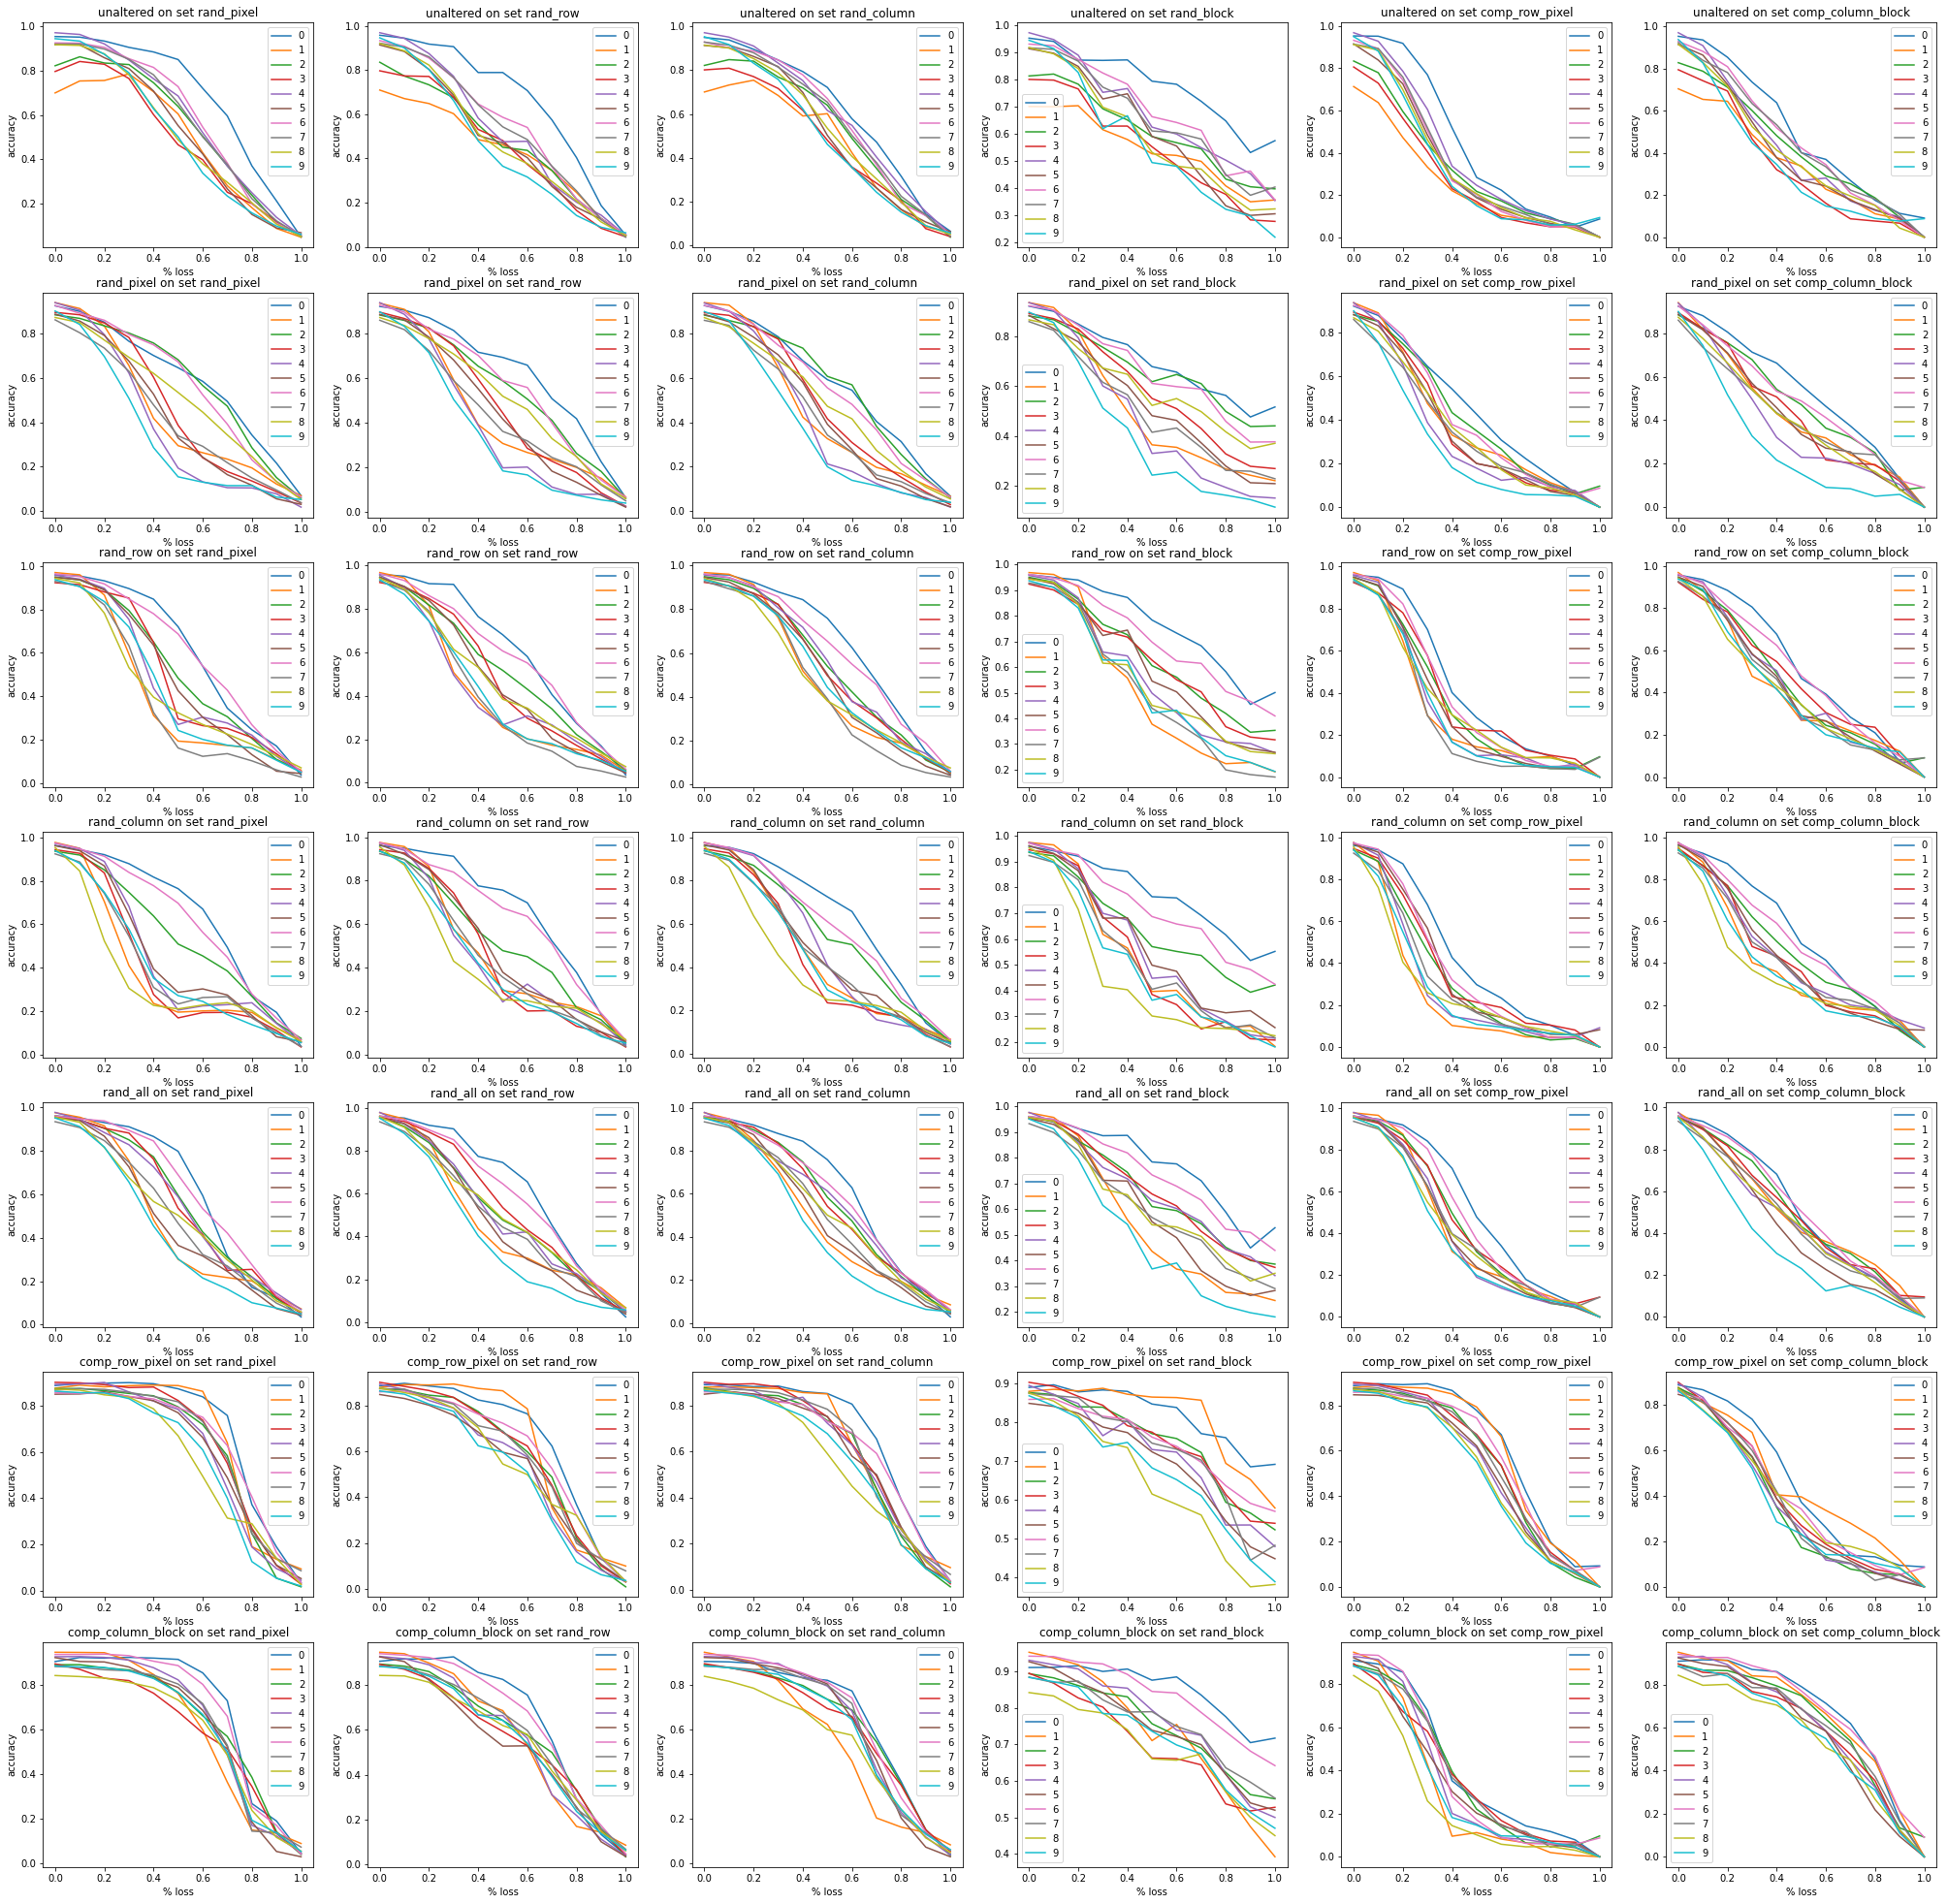

In [180]:
fig, axarr = plt.subplots(len(crosstab.keys()), len(crosstab[list(crosstab.keys())[0]].keys()),figsize=(35,35))
for i, model in enumerate(crosstab.keys()):
    for j, func in enumerate(crosstab[model].keys()):
        plt.sca(axarr[i, j])#
        stats = vis_metrics(crosstab[model][func])
        for k in range(10):
            sns.lineplot(y=stats['accuracy'][k],x=[x/10 for x in range(11)],legend=True)
        plt.legend([i for i in range(10)])
        plt.xlabel('% loss')
        plt.ylabel('accuracy')
        plt.title("{} on set {}".format(model,func))
        #display_testing_metrics("{} on set {}".format(model,func),crosstab[model][func])
#leg = ['precision','recall','accuracy']
#plt.legend(leg)

# Investigate Model Features

unaltered
tensor([9, 3, 5, 4, 6], device='cuda:0')


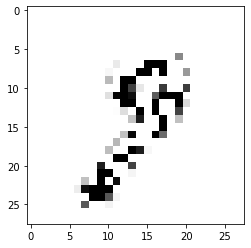

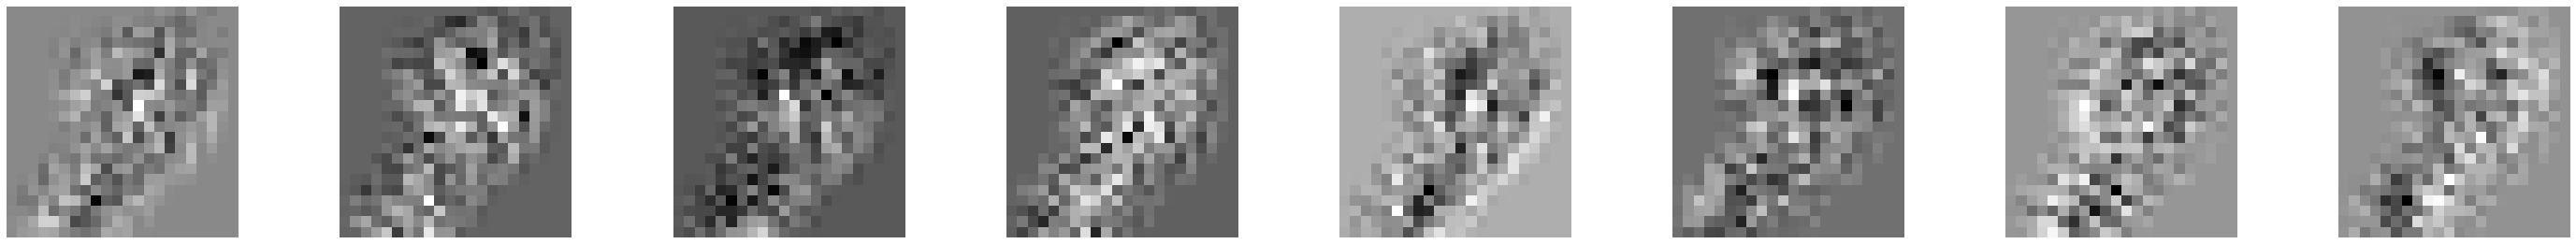

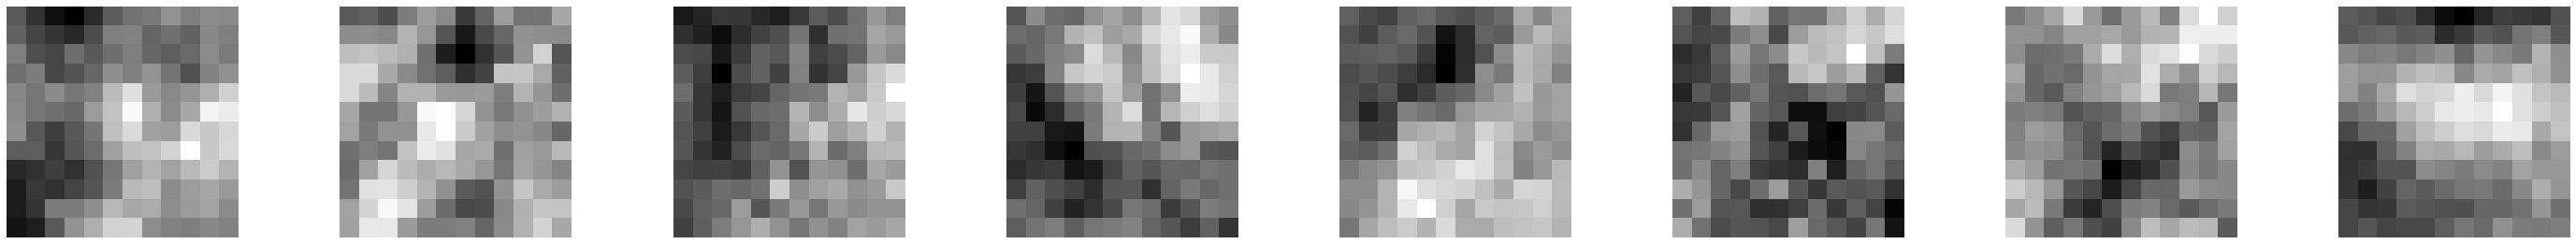

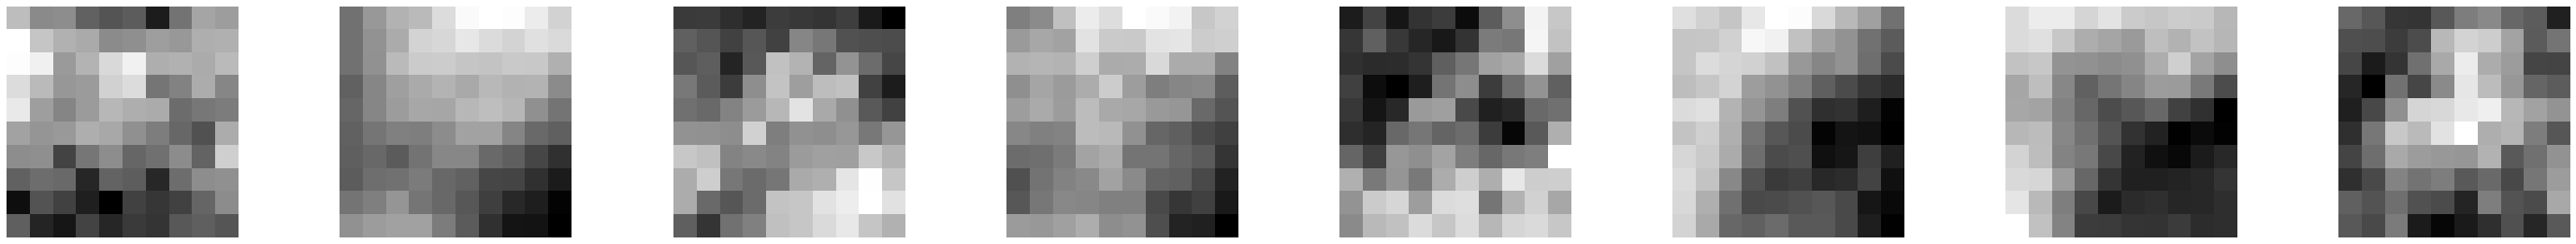

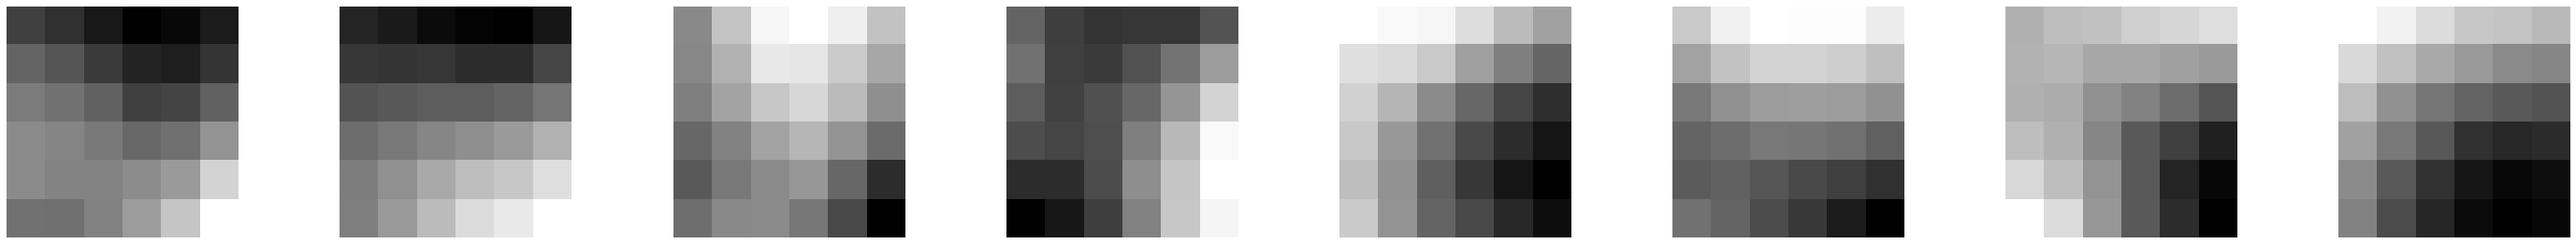

rand_pixel
tensor([7, 3, 5, 4, 2], device='cuda:0')


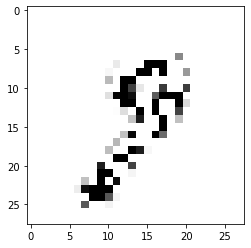

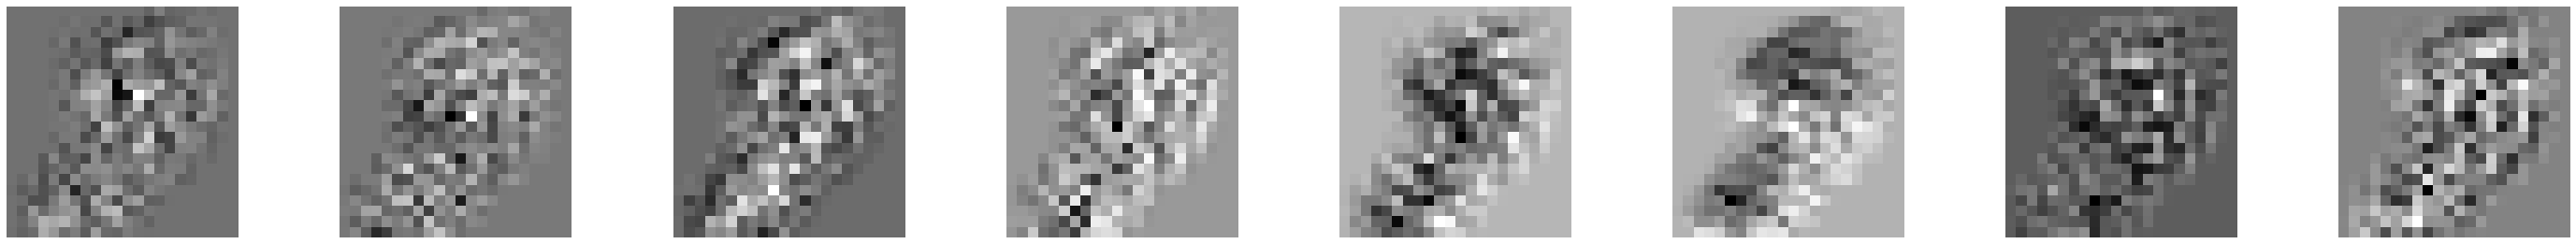

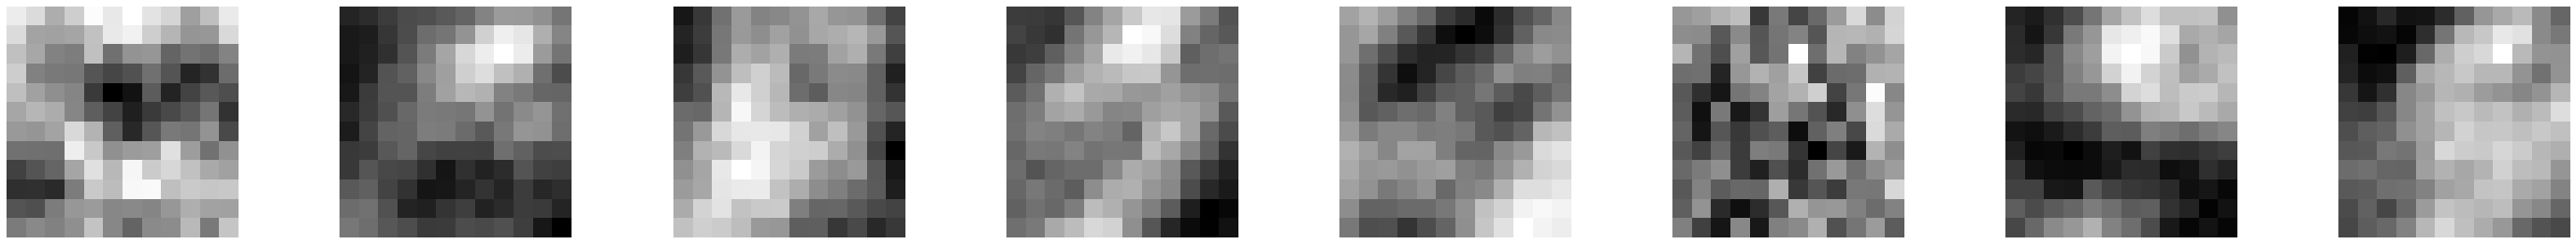

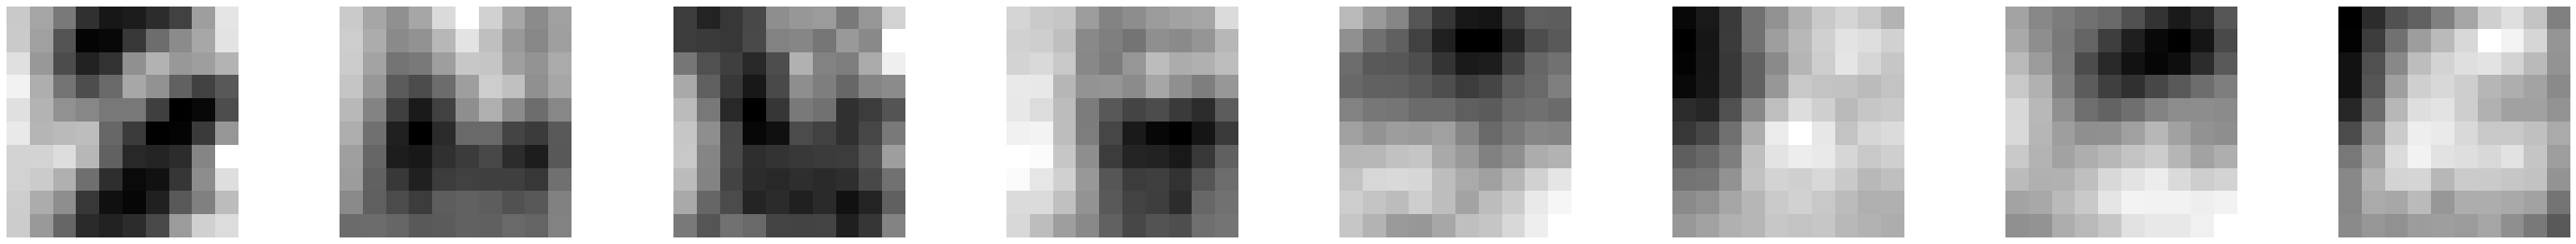

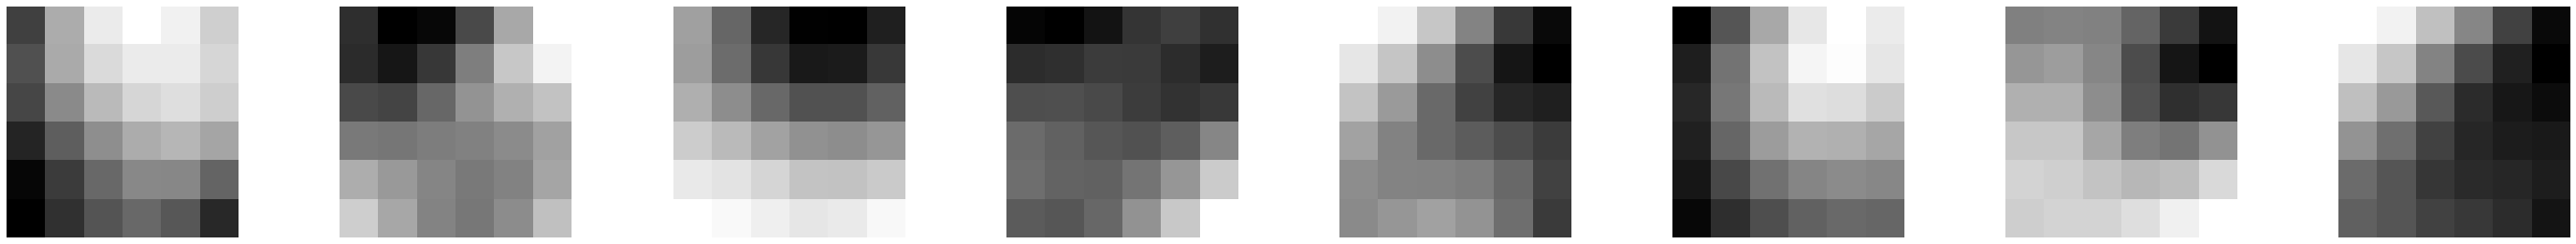

rand_row
tensor([9, 3, 5, 4, 8], device='cuda:0')


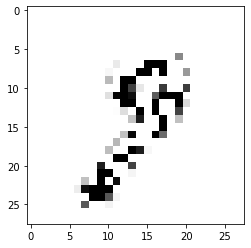

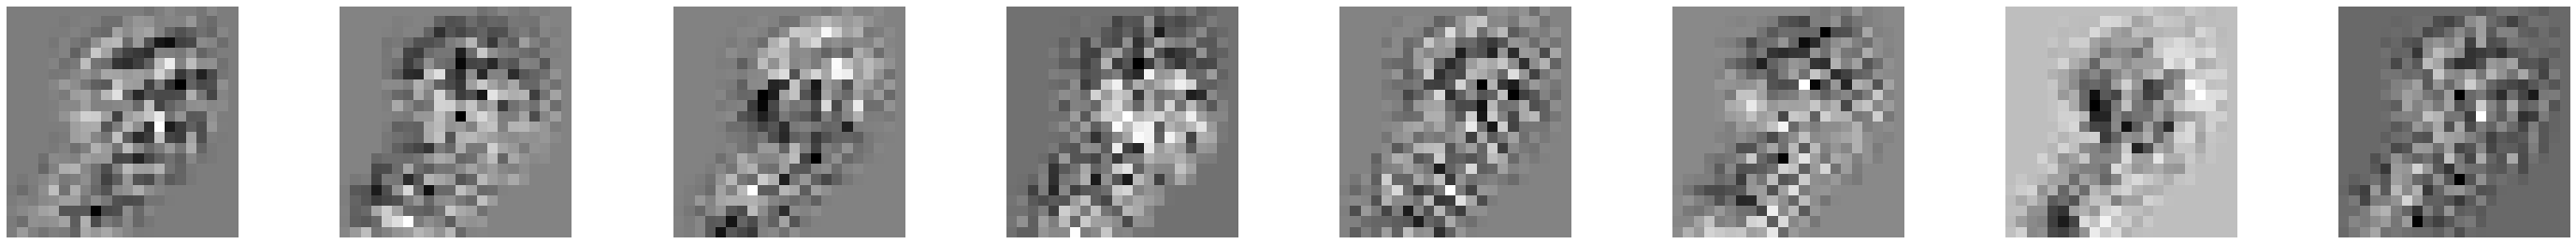

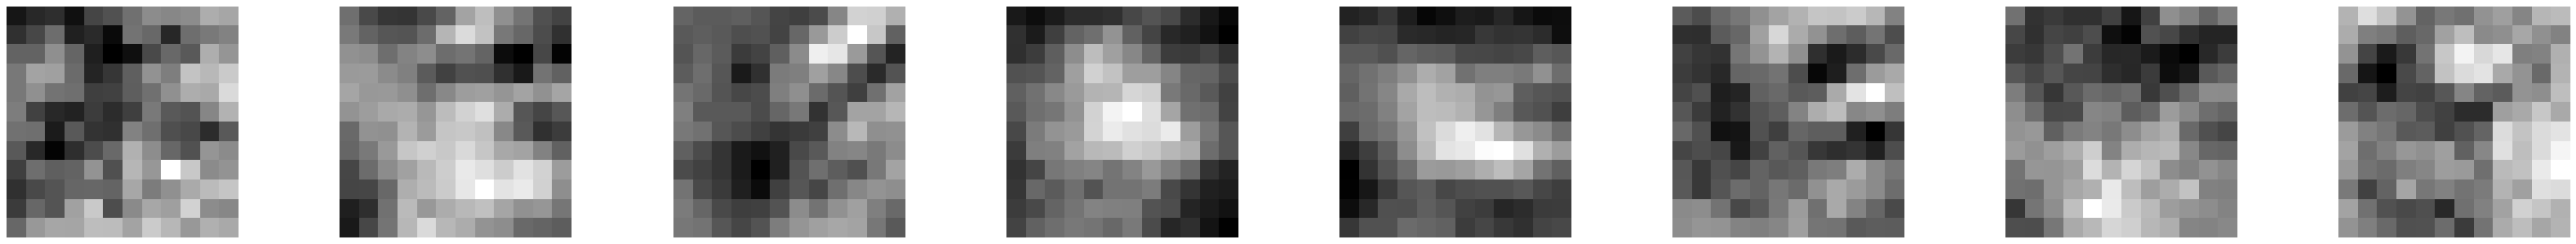

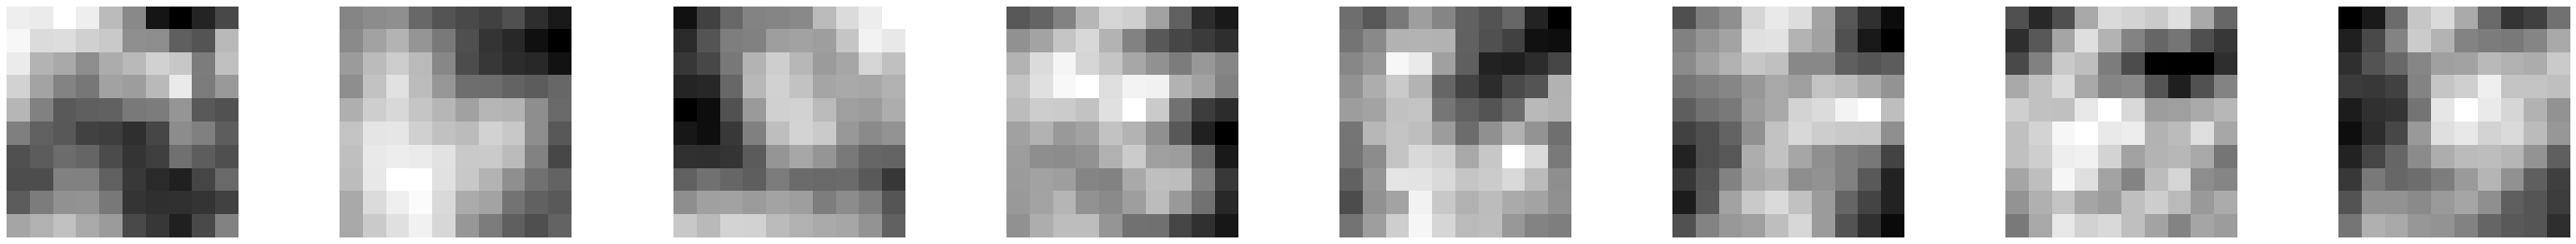

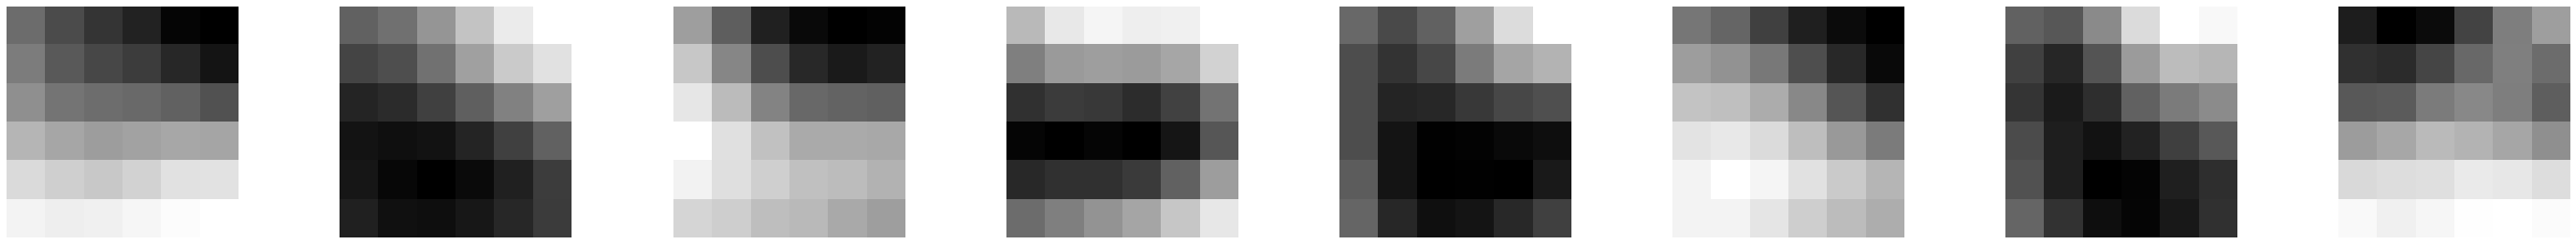

rand_column
tensor([9, 3, 5, 4, 2], device='cuda:0')


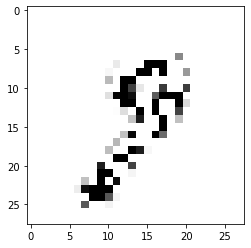

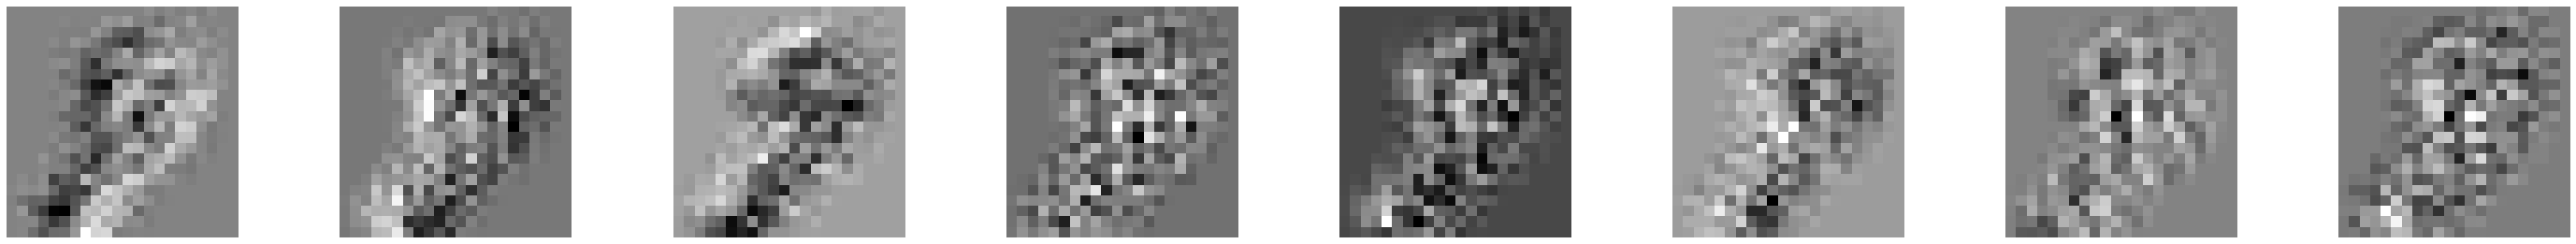

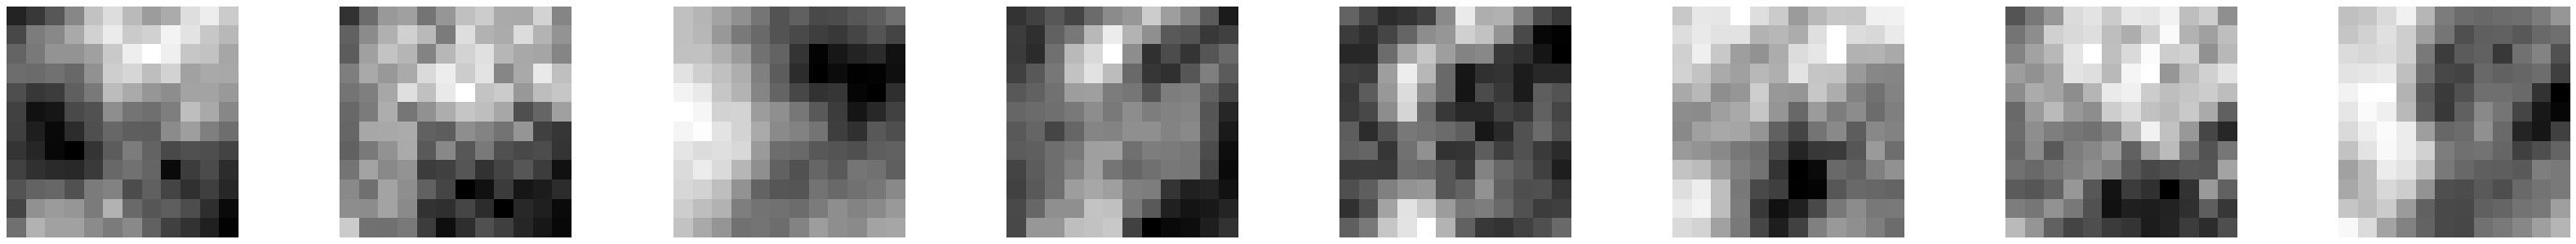

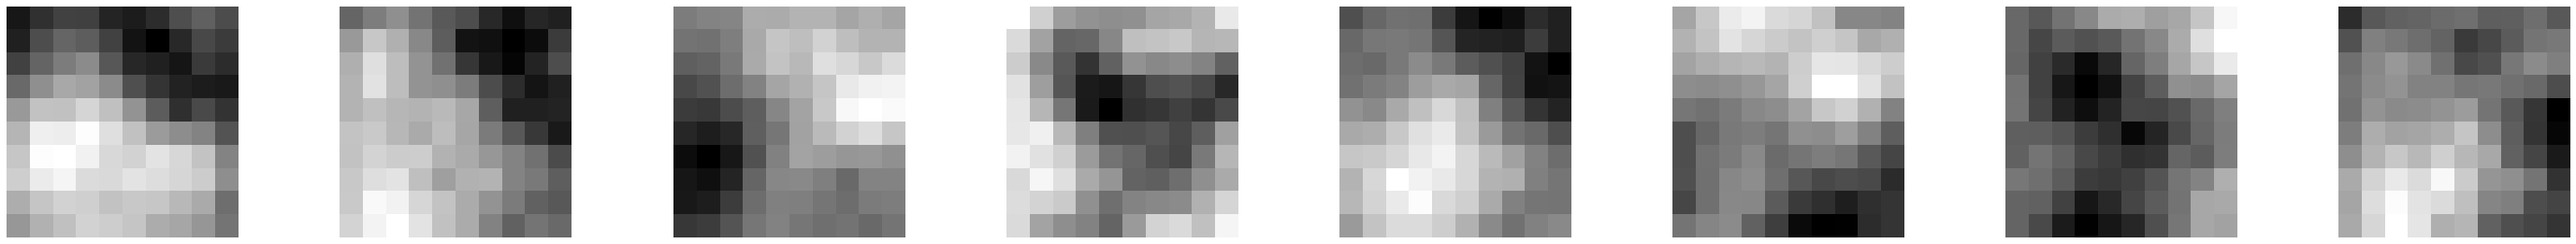

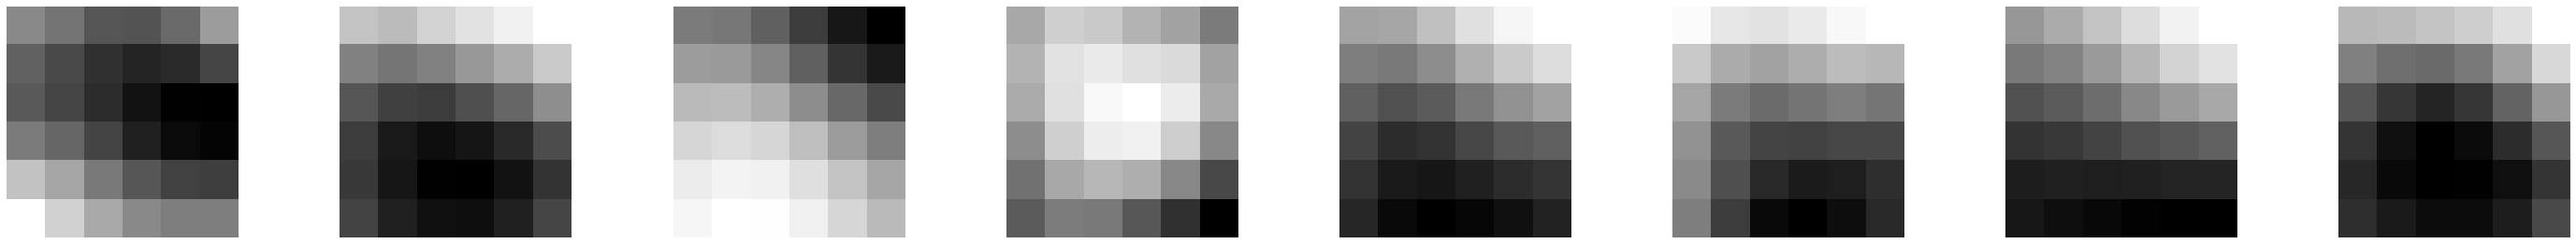

rand_all
tensor([9, 3, 5, 4, 0], device='cuda:0')


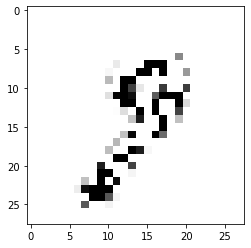

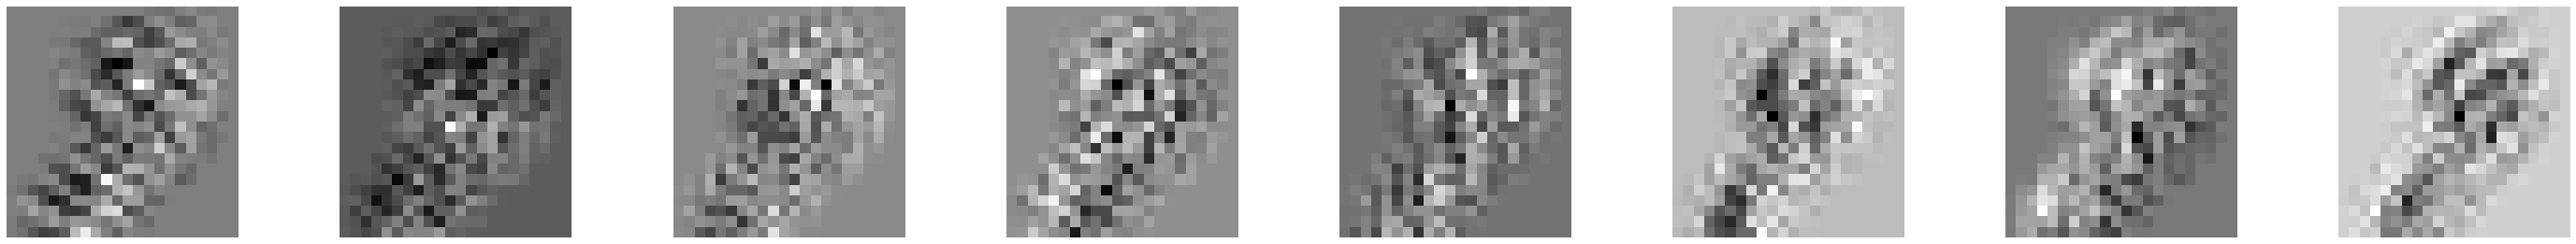

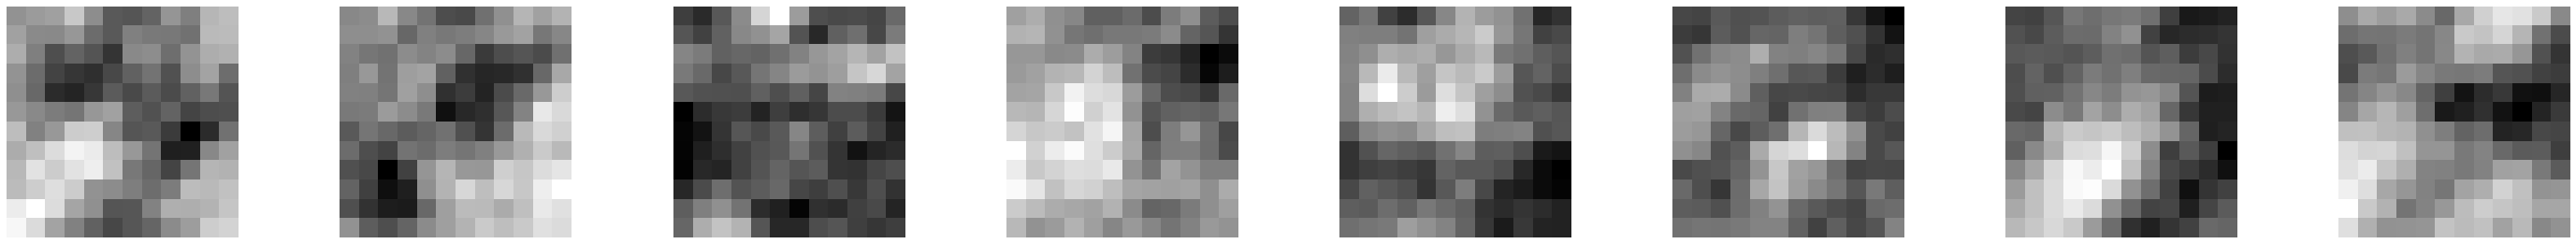

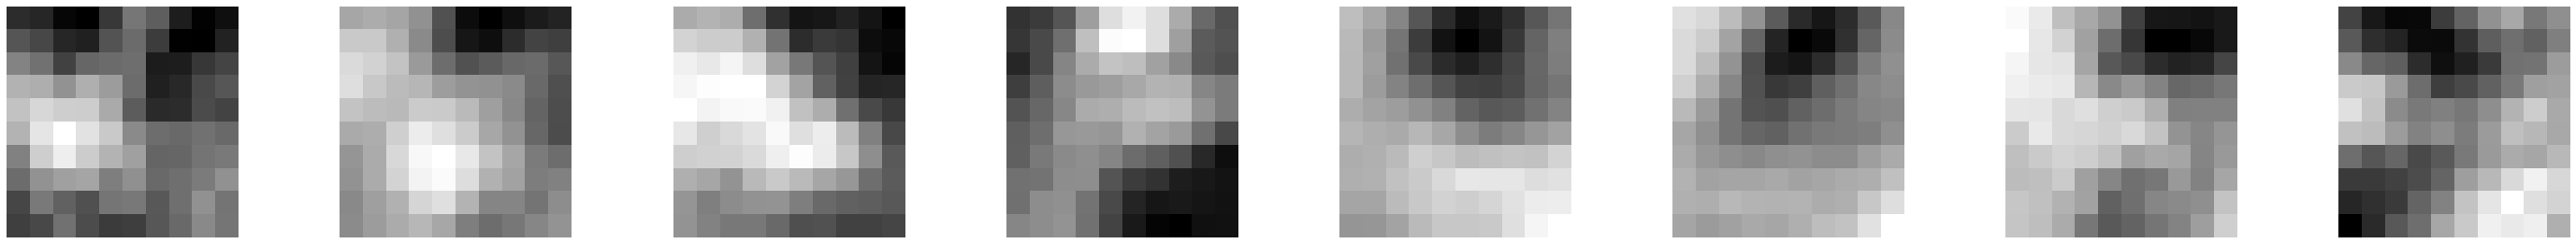

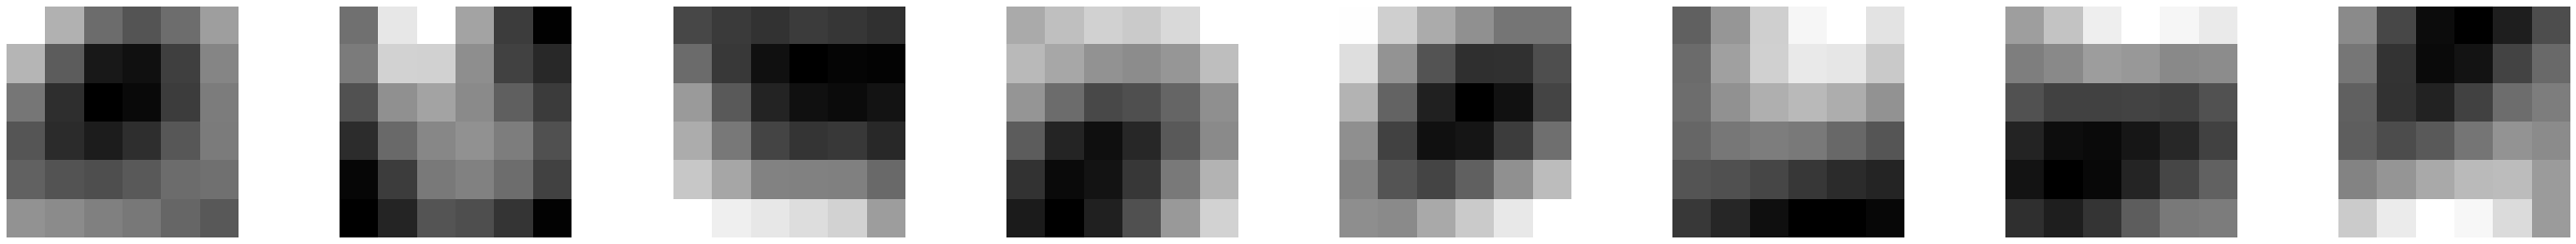

comp_row_pixel
tensor([9, 3, 9, 5, 6], device='cuda:0')


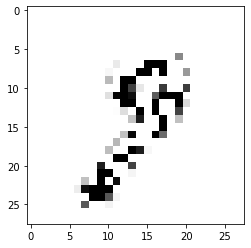

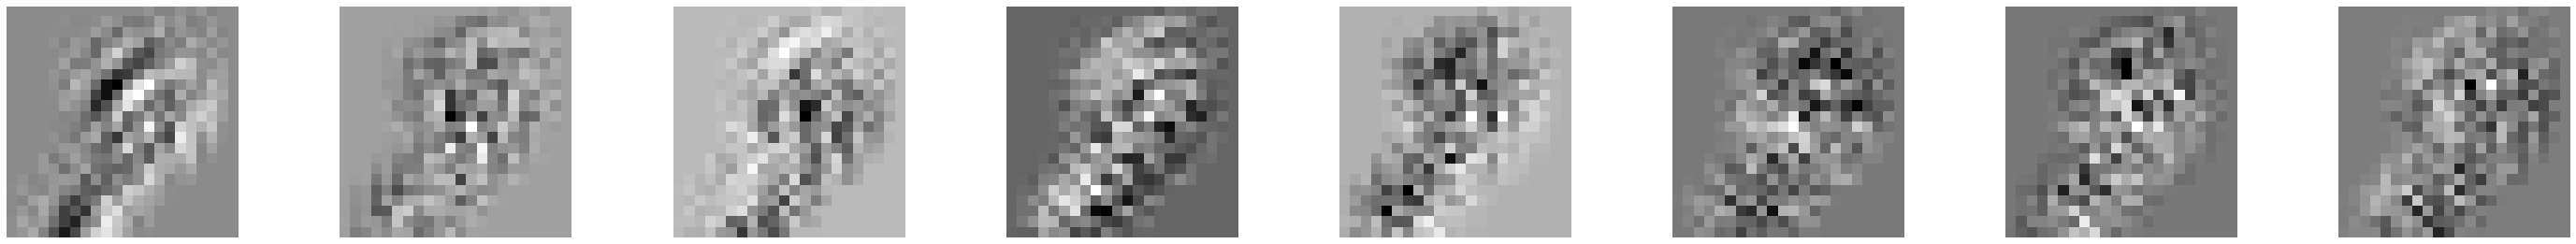

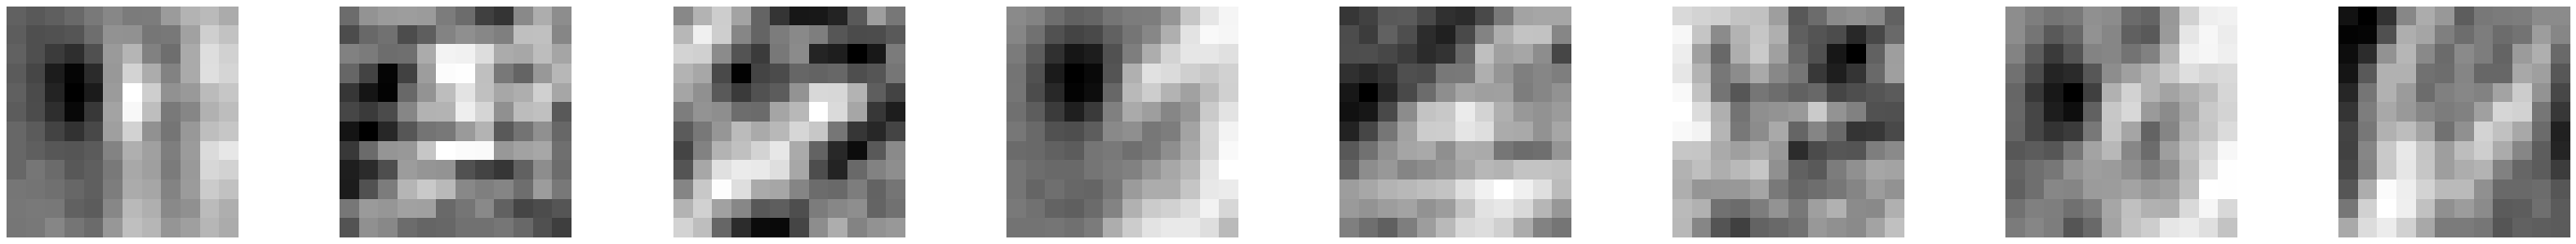

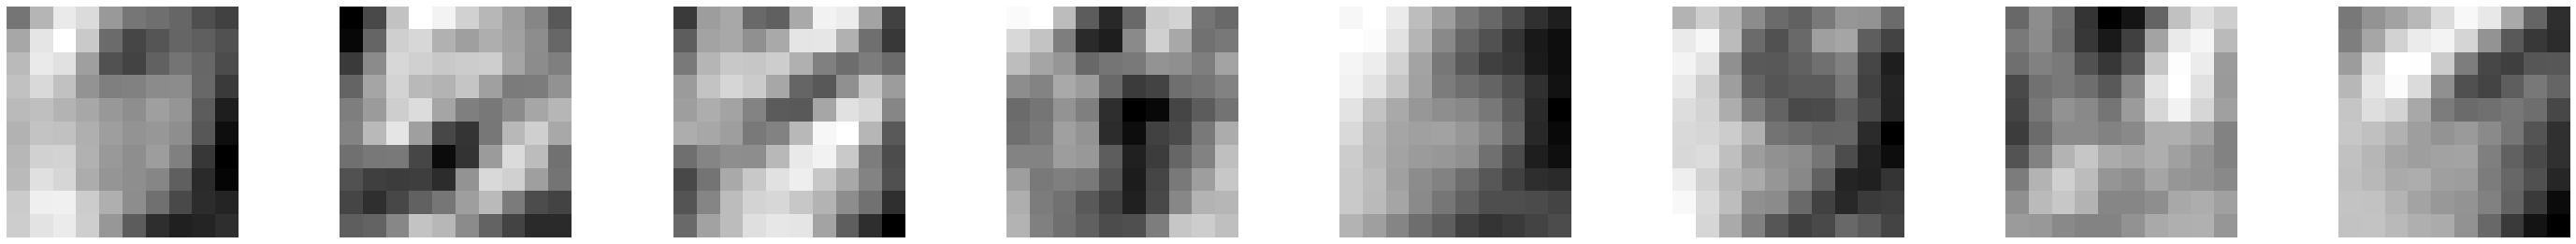

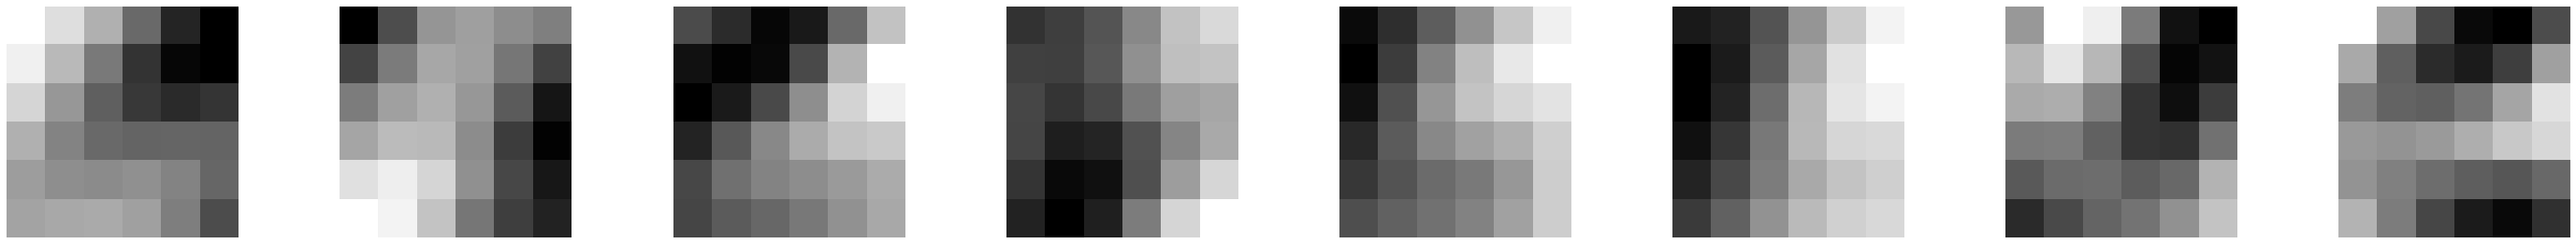

comp_column_block
tensor([9, 3, 0, 2, 6], device='cuda:0')


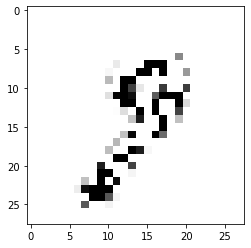

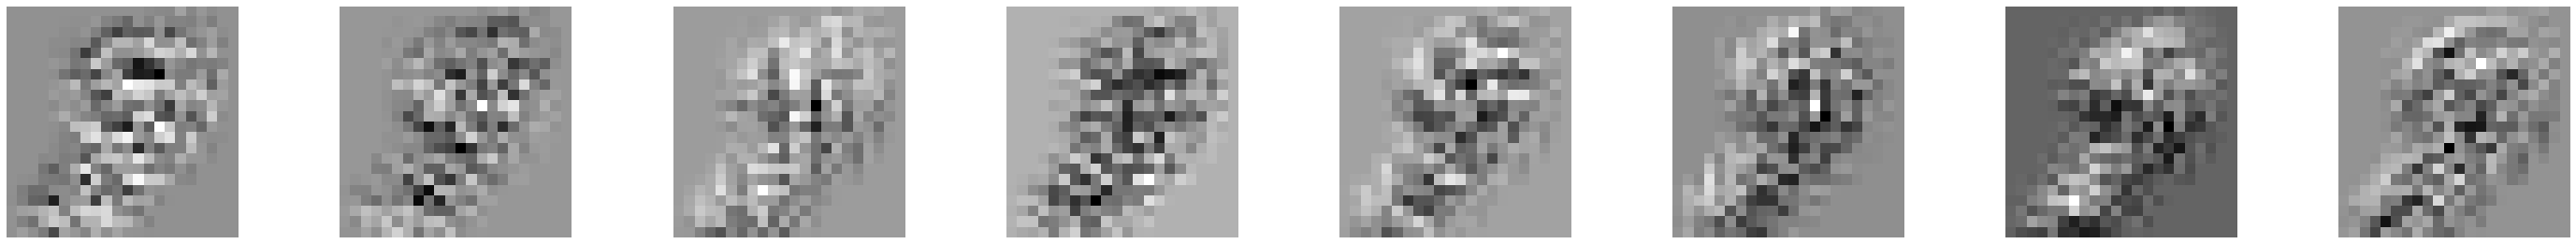

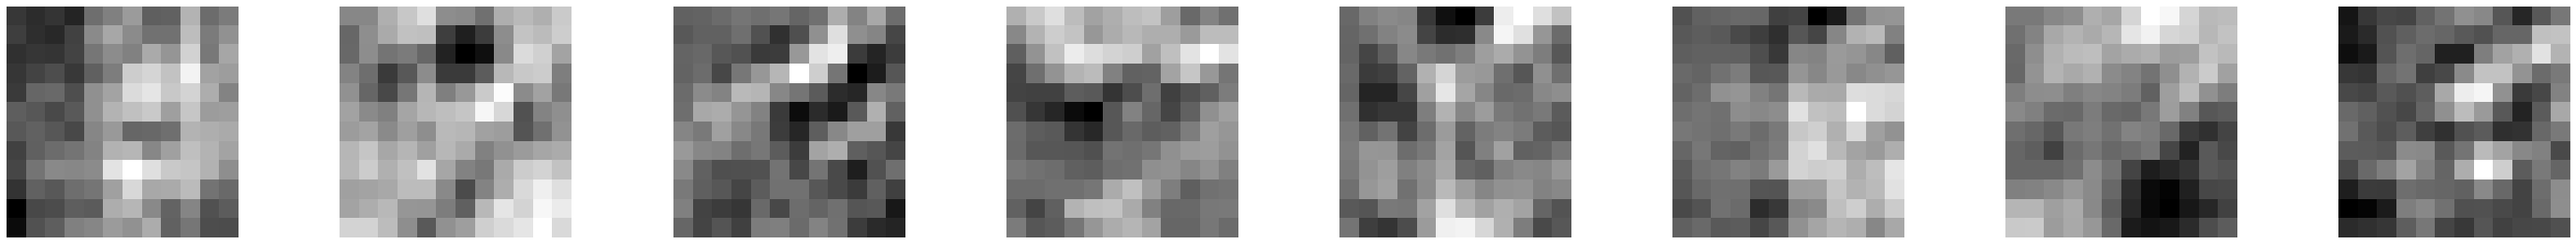

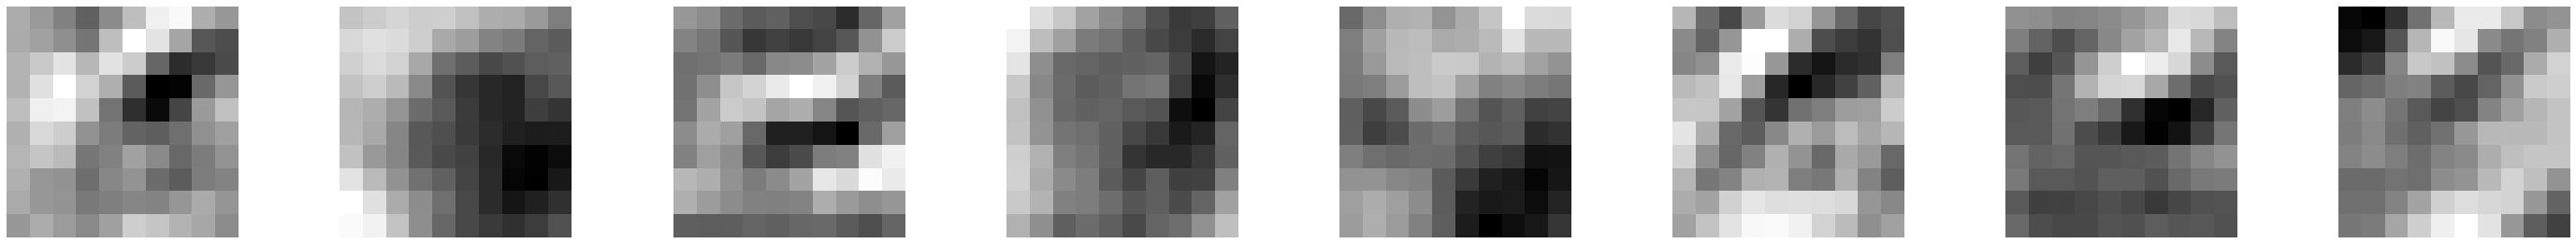

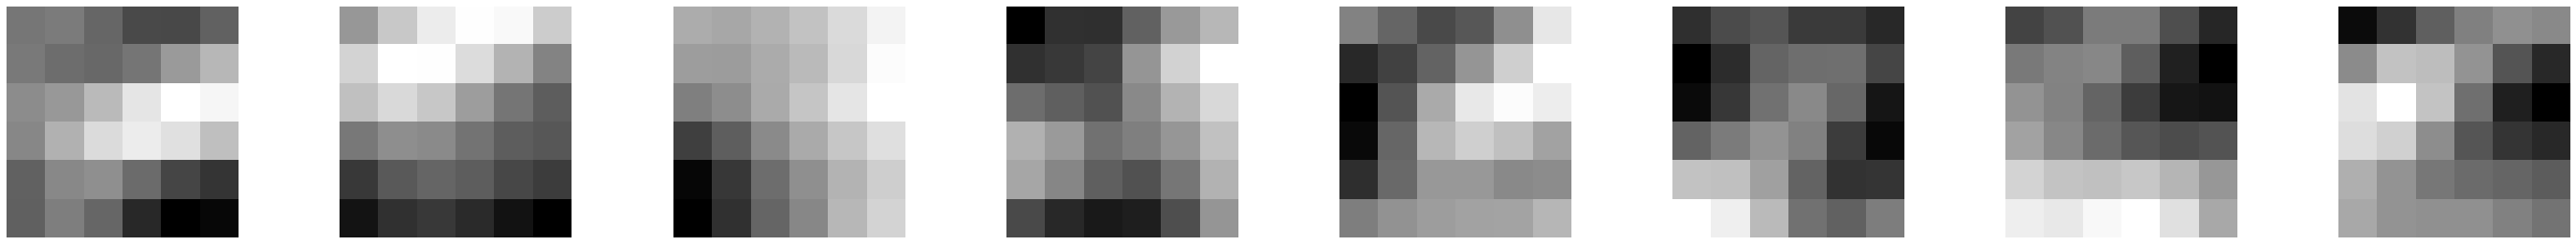

In [182]:
(inputs, labels) = next(iter(test_loader))
inputs = daug.rand_pixel(inputs,0.5,False)[0:5]
for mname in model_dict:
    print(mname)
    print(model_dict[mname](inputs.to(device)).argmax(1))
    metric.feature_map(inputs.to(device),model_dict[mname],device,True)